In [1]:
import h5py
%pylab
%matplotlib inline
import sys
print(sys.version)
from numba import njit,prange
import xarray as xr
import pandas as pd
from netCDF4 import Dataset
import eccodes

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


ModuleNotFoundError: No module named 'eccodes'

## Avoiding common python performance pitfalls when using xarray or pandas

- Credo: xarray, pandas are neat, useful for teaching, fast with some operations, but some functions are poorly implemented. 
- Some of those are highlighted and workarounds using numpy, numba are presented
- first part is on accessing a 3D regular gridded .nc file
    - read speed
    - computation speed
- second part is on accessing a table-like .nc timeseries file
    - date selection
    
- Way of demonstration: In each code cell we present a "standard" way and one or two alternative faster ways. After each code cell there is a discussion cell interpreting the results


### Example: Find minimum pressure of zero degree line and where it varies the most in time in the given month

(124, 181, 360)
3.604 sec
521.8829
-46.0 0.0 53.60556


C:\Users\leopo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


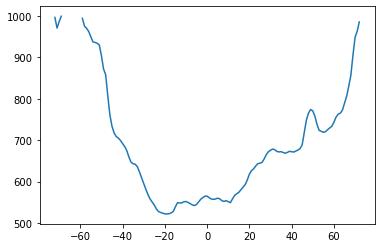

In [200]:
def pzero(p,t): # function returns estimated pressure of first occurence of zero degree level when moving from 200hPa downward.
                # If all temperatures are below zero it returns NaN
    idx=where(t>273.15)[0]
    if len(idx)>0:
        pz=((273.15-t[idx[0]-1])*p[idx[0]]+(t[idx[0]]-273.15)*p[idx[0]-1])/(t[idx[0]]-t[idx[0]-1])
        return pz
    else:
        return NaN

def pzerostd(T,pzeros): # calculates standard deviation of zero degree pressure level
    varpzero=nanstd(pzeros,axis=0)
    iflat=nanargmax(varpzero)
    mlat=iflat//varpzero.shape[1]
    mlon=iflat%varpzero.shape[1]
    print(T.latitude.values[mlat],T.longitude.values[mlon],varpzero[mlat,mlon])

def zerostd(T,ifile): # calculates zero degree pressure level for some  lats,lons,times
    pzeros=full([T.shape[0],T.shape[2],T.shape[3]],NaN,dtype=float32)
    print(pzeros.shape)
    tt=time.time()
    for itime in range(2): #T.shape[0]):
        for ilat in range(0,T.shape[2]):
            for ilon in range(1):
                pzeros[itime,ilat,ilon]=pzero(T.level[7:],T[itime,7:,ilat,ilon])
                #print(T[itime,7:,ilat,ilon])
        
    plot(T.latitude,pzeros[0,:,0])
    print('{:5.3f} sec'.format(time.time()-tt))
    print(nanmin(pzeros[pzeros>0]))
    pzerostd(T,pzeros)
            #print(itime)

ifile='era5.202001.130.nc'
T=xr.open_dataarray(ifile)
zerostd(T,ifile)


### Discussion:
- Function pzero is called for every atmospheric column in the month (ca 7 million times)
- Function pzero analyzes the t-profile from 200 hPa (level 7) downward. It looks for the first occurence of a temperature above zero C. Then it approximates the zero level by linear interpolation
- Function pzero is called with slices of xarray objects - (9 plevels and T values). This involves lots of overhead for copying metadata
- array pzeros contains pressure values of zero deg at every time,lat,lon - use numpy functions to find minimum, location of maximum variance
- Note time loop goes only to 2 instead of 124 and lon loop has only one value. Otherwise this evaluation would take more than an hour!


In [201]:
def zerostd2(T,ifile):
    pzeros=full([T.shape[0],T.shape[2],T.shape[3]],NaN,dtype=float32)
    print(pzeros.shape)
    tt=time.time()
    levs=T.level[7:].values
    Ts=T[:,7:,:,:].values
    for itime in range(2): #T.shape[0]):
        for ilat in range(T.shape[2]):
            for ilon in range(1):
                pzeros[itime,ilat,ilon]=pzero(levs,Ts[itime,:,ilat,ilon])
        
    print('{:5.3f} sec'.format(time.time()-tt))
    #plot(T.latitude,pzeros[0,:,0])
    print(nanmin(pzeros[pzeros>0]))
    pzerostd(T,pzeros)
zerostd2(T,ifile)


(124, 181, 360)
0.828 sec
521.8829
-46.0 0.0 53.60556


### Discussion:
- zerostd2 now calls pzeros as above, but with numpy arrays instead of xarray objects
- This leads to a 2.1x speedup, but performance is still not exciting

In [202]:
@njit   # The njit decorator induces compilation of the function, allowing speeds similar to C and Fortran. Works only with numpy arrays
def pzeroarr(p,t,pz):
    for itime in range(t.shape[0]): #t.shape[0]):
        for ilat in range(0,t.shape[2]):
            for ilon in range(t.shape[3]):
                idx=where(t[itime,7:,ilat,ilon]>273.15)[0]
                if len(idx)>0:
                    pz[itime,ilat,ilon]=((273.15-t[itime,7+idx[0]-1,ilat,ilon])*p[7+idx[0]]+(t[itime,7+idx[0],ilat,ilon]-273.15)*p[7+idx[0]-1])/\
                    (t[itime,7+idx[0],ilat,ilon]-t[itime,7+idx[0]-1,ilat,ilon])
                else:
                    pass
    return pz



### Discussion: 
- In the above examples, we called a user defined function 7 million times. This potentially causes a lot of overhead. To avoid this we "inline" the zero temperature pressure calculation.  
- The pzeroarr function can again be called with xarray or numpy array arguments.
- When called with numpy arrays we can activate the @njit decorator, which compiles the function to machine code. 

In [203]:
def zerostd3(T,ifile):
    pzeros=full([T.shape[0],T.shape[2],T.shape[3]],NaN,dtype=float32)
    print(pzeros.shape)
    tt=time.time()
    #pzeros=pzeroarr(T.level,T,pzeros) # call with xarray objects
    pzeros=pzeroarr(T.level.values,T.values,pzeros)
        
        #plot(T.latitude,pzeros[0,:,0])
    print('{:5.3f} sec'.format(time.time()-tt))
    print(nanmin(pzeros[pzeros>0]))
    pzerostd(T,pzeros)
zerostd3(T,ifile)


(124, 181, 360)
3.749 sec
473.6386
40.0 288.0 118.89815


C:\Users\leopo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Discussion:
- When we call the pzeroarr function with xarray arguments, the calculation still takes 1.4 seconds for 1 longitude and 2 latitudes -> no speedup.
- If we call it with numpy arrays instead, the calculation is finished in 0.04 seconds. When we loop over the full range it is finished after 64 seconds. A 30x speedup!
- If we call it with numpy arrays, we can also compile the function (with the @njit decorator). Now the calculation finishes after 1.5 seconds! A 1200x speedup!

In [204]:
@njit(fastmath=True,parallel=True)
def pzeroarr2(p,t,pz):
    for itime in prange(t.shape[0]): #T.shape[0]):
        for ilat in range(0,t.shape[2]):
            for ilon in range(t.shape[3]):
                idx=7
                while t[itime,idx,ilat,ilon]<273.15:
                    idx+=1
                    if idx==t.shape[1]:
                        break
                if idx<t.shape[1]:
                    pz[itime,ilat,ilon]=((273.15-t[itime,idx-1,ilat,ilon])*p[idx]+(t[itime,idx,ilat,ilon]-273.15)*p[idx-1])/\
                    (t[itime,idx,ilat,ilon]-t[itime,idx-1,ilat,ilon])
                else:
                    pass
    return pz



### Discussion:
- The pzeroarr function has this call to numpy.where. This is not overly efficient, since it returns the indices of all values with T>0 at one lat/lon/time. We need only the first index. 
- Since we compile the function with @njit, which speeds up loops dramatically, we replace the numpy.where function with a while loop. Since T normally rises monotonically, we can break out of the loop if the first value>0 C is found. 
- We also avoid double indexing.

In [205]:
def zerostd3(T,ifile):
    ttt=time.time()
    pzeros=full([T.shape[0],T.shape[2],T.shape[3]],NaN,dtype=float32)
    print(pzeros.shape)
    tt=time.time()
    pzeros=pzeroarr2(T.level.values,T.values,pzeros)
    print('{:5.3f} sec'.format(time.time()-tt))        
        #plot(T.latitude,pzeros[0,:,0])
    print(nanmin(pzeros[pzeros>0]))
    pzerostd(T,pzeros)
    print('Total {:5.3f} sec'.format(time.time()-ttt))        
    
zerostd3(T,ifile)

(124, 181, 360)
0.822 sec
473.6386
40.0 288.0 118.89815
Total 0.926 sec


C:\Users\leopo\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Discussion: 
- Avoiding the while loop gives us another 20x speedup. Total speedup 25000x!
- We can improve even more if we use the fastmath option (5%)
- Using the parallel option and prange for the outer loop, we get another 2.2x speedup on my 4 core laptop. Speedup of the 0 C level calculation is now 50k, that means 0.03 sec instead of more than an hour!
- Now the other functions (reading the file, finding the mean and standard deviation) take most of the time. 

## Part 2 # Efficient read of non-gridded observation data
Also reading 1D data can pose performance challenges. This section gives a few hints for efficient searching  of tables.

### Discussion:
- This is a complicated netcdf files with several tables, organized into groups. The largest table is the observations_table, which can be selected with the group option.
- The table consists of 46 columns and 67 million rows. 
- The table is sorted along columns observed_variable, date_time and z_coordinate

### Task: Extract time series of 0 C pressure, as for the gridded data, check if there is a negative trend. 
- we know that the observed_variable value for temperature is 85 and that pressure is measured in Pa.
- Number of pressure levels varies per ascent. ~10 at the beginning, several 100 near the end.
- The time comes in xarray as datetime64 object.
- Let's plot the time series first, say on the 500 hPa level. 

In [206]:
ifile='0-20001-0-11035_CEUAS_merged_v1.nc'
tt=time.time()
a=xr.open_dataset(ifile,group='observations_table')
print(a)
print('{:5.3f} sec'.format(time.time()-tt))   

<xarray.Dataset>
Dimensions:                                   (index: 67784826)
Coordinates:
  * index                                     (index) |S1 b'' b'' ... b'' b''
Data variables: (12/46)
    adjustment_id                             (index) float32 ...
    advanced_assimilation_feedback            (index) int32 ...
    advanced_homogenisation                   (index) int32 ...
    advanced_qc                               (index) int32 ...
    advanced_uncertainty                      (index) int32 ...
    bbox_max_latitude                         (index) float32 ...
    ...                                        ...
    traceability                              (index) int32 ...
    units                                     (index) int32 ...
    value_significance                        (index) int32 ...
    z_coordinate                              (index) float32 ...
    z_coordinate_method                       (index) int32 ...
    z_coordinate_type                      

4.416 sec
7.659 sec
13276
<xarray.DataArray 'observation_value' (index: 25)>
array([214.7, 216.5, 214.1, 216.9, 218.5, 298.2, 215.5, 218.3, 214.1, 210.9,
       216.3, 231.5, 233.1, 244.7, 261.3, 265.9, 269.1, 275.8, 276.2, 276.6,
       275.2, 277. , 277.2, 276.6, 277.6], dtype=float32)
Coordinates:
  * index    (index) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
<xarray.DataArray 'z_coordinate' (index: 25)>
array([10000., 12000., 13500., 15000., 16000., 20000., 22000., 23700., 25000.,
       26800., 30000., 40000., 41100., 50000., 64800., 70000., 73800., 83200.,
       85000., 86800., 87500., 93000., 94900., 95800., 98700.], dtype=float32)
Coordinates:
  * index    (index) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
<xarray.DataArray 'z_coordinate_type' (index: 25)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])
Coordinates:
  * index    (index) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''


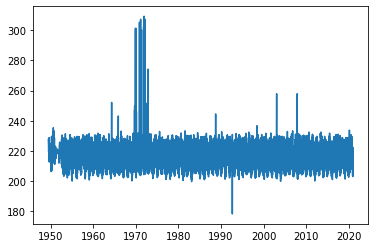

In [207]:
tt=time.time()
idx=where(logical_and(a.observed_variable==85,a.z_coordinate==20000))
print('{:5.3f} sec'.format(time.time()-tt))        
plot(a.date_time[idx],a.observation_value[idx])
print('{:5.3f} sec'.format(time.time()-tt))   
idy=where(a.observation_value[idx]>273.15)
print(idy[0][0]),idx[0].shape
print(a.observation_value[idx[0][idy[0][0]]-5:idx[0][idy[0][0]]+20])
print(a.z_coordinate[idx[0][idy[0][0]]-5:idx[0][idy[0][0]]+20])
print(a.z_coordinate_type[idx[0][idy[0][0]]-5:idx[0][idy[0][0]]+20])


In [208]:
@njit   # The njit decorator induces compilation of the function, allowing speeds similar to C and Fortran. Works only with numpy arrays
def pzerots(p,t,T):
    ts=[]
    ps=[]
    pfound=False
    rcount=0 # record count
    for iobs in range(1,T.shape[0]):
        if t[iobs]!=t[iobs-1] and p[iobs]<p[iobs-1]:
            rcount+=1
            pfound=False
#            if rcount%100==0:
#                print(rcount)
        if T[iobs]>273.15 and T[iobs-1]<273.15 and p[iobs]>40000 and not pfound:
            pz=((273.15-T[iobs-1])*p[iobs]+(T[iobs]-273.15)*p[iobs-1])/\
                (T[iobs]-T[iobs-1])
            #print(pz)
            ps.append(pz)#.values)
            ts.append(t[iobs])#.values)
            pfound=True
        #print(iobs)
    return array(ts),array(ps)


### Discussion:
- From what we learned above, we start with a function that can be compiled with njit if a numpy array is supplied.
- We assume only temperature data are selected
- We need to take into account varying pressure level numbers.

3320215
2.667 sec
4.842 sec


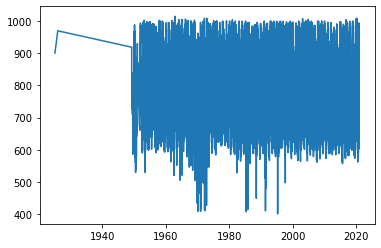

In [209]:
tt=time.time()
idx=where(logical_and(a.observed_variable==85,a.z_coordinate>=20000))
print(len(idx[0]))
print('{:5.3f} sec'.format(time.time()-tt))   ; tt=time.time()     
ts,ps=pzerots(a.z_coordinate.values[idx],a.date_time.values[idx],a.observation_value.values[idx])
print('{:5.3f} sec'.format(time.time()-tt))        
plot(ts,ps/100)

### Discussion:
- using xarray variables is again extremely slow. Processing the first 100 of 3.3 Million relevant observations takes 20 seconds!
- using numpy array variables yields a 7x speedup, but still not acceptable for real world applications
- using numpy array with njit takes 0.026 seconds, an 800x speedup.
- using numpy and njit for only 100 values has some overhead for loading the compiled function. When iterating over all values, the result is 0.038 sec for 3.3 Million obs, i.e. a speedup by 6 orders of magnitude.

### Can we reduce the reading overhead?
- temperature values are a chunk in file
- file is indexed

3320215
0.144 sec
0.059 sec


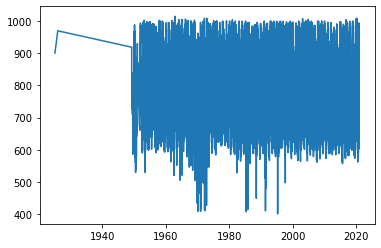

In [210]:
tt=time.time()
idx=np.where(a.observed_variable.values==85)
irange=[idx[0][0],idx[0][-1]+1]
idx=where(a.z_coordinate[irange[0]:irange[1]]>=20000)[0]
print(len(idx))
print('{:5.3f} sec'.format(time.time()-tt))   ; tt=time.time()     
ts,ps=pzerots(a.z_coordinate.values[irange[0]+idx],a.date_time.values[irange[0]+idx],a.observation_value.values[irange[0]+idx])
print('{:5.3f} sec'.format(time.time()-tt))        
plot(ts,ps/100)

### Discussion:
- Concentrating just on the chunk where Temperature values are helps a lot
- Only one variable (a.observed_variable) had to be read in full. Speedup by factor 12
- This makes also the call to pzerots faster (only chunks of the z_coordinate, date_time, observation_value are read). Speedup by factor 4

### Can we still do better? (e.g. for calculating trends for all stations worldwide)? 

<HDF5 file "0-20001-0-11035_CEUAS_merged_v1.nc" (mode r)>
[22716742, 29064776]
3320215
0.504 sec
0.516 sec


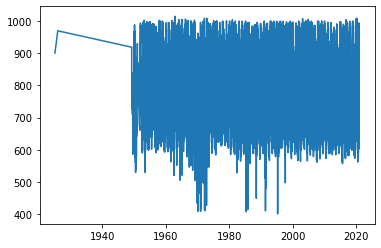

In [211]:
try:
    del a # needed to get read access via h5py
except:
    pass
tt=time.time()
ifile='0-20001-0-11035_CEUAS_merged_v1.nc'
f=h5py.File(ifile,'r')
print(f)
irange=[f['recordindices']['85'][0],f['recordindices']['85'][-1]]
print(irange)
a=f['observations_table']
idx=where(a['z_coordinate'][irange[0]:irange[1]]>=20000)[0]
print(len(idx))
az,adate,aobs=a['z_coordinate'][irange[0]:irange[1]][idx],a['date_time'][irange[0]:irange[1]][idx],\
                a['observation_value'][irange[0]:irange[1]][idx]
print('{:5.3f} sec'.format(time.time()-tt))   ; tt=time.time()

ts,ps=pzerots(az,adate,aobs)
print('{:5.3f} sec'.format(time.time()-tt)) 
ts=pd.to_datetime(ts, unit='s',origin=pd.Timestamp('1900-01-01'))
plot(ts,ps/100)
f.close()

### Discussion
- h5py does not seem faster here reading the variables, but remember that simply opening the file with xarray.open_dataset took 1.2 secs
- if the pzerots function can be called with references to variables, the pzerots function is another 10x faster than when called with numpy slices.
- date_time variable is integer in h5py (seconds since 19000101). Can be converted efficiently to date_time with pandas function. 


### Implementing this in pandas
- pandas is a powerful tool for managing and displaying tables. It should be ideal for working with observations data.
- still there are some faster alternatives for popular pandas functions.
- netCDF files are not directly supported by pandas. One needs to read it via xarray (slow, memory intensive) or h5py to get it into pandas form

In [212]:
#b=a.to_dataframe() This fails in this case because of a memory error.

In [213]:
tt=time.time()
df=pd.DataFrame()
with h5py.File(ifile) as f:
    for k in f['observations_table'].keys():
        if f['observations_table'][k][0].dtype=='S1':
            print(k,f['observations_table'][k].shape,f['observations_table'][k][:3].view('S{}'.format(f['observations_table'][k].shape[1])).flatten())
            #df[k]=f['observations_table'][k][:].view('S{}'.format(f['observations_table'][k].shape[1])).flatten()
        elif k in ['observation_value','observed_variable','date_time','z_coordinate']:
            df[k]=f['observations_table'][k][:]
#print(df.date_time)
print(std(df.observation_value[logical_and(logical_and(df.observed_variable==85,df.z_coordinate==50000),df.date_time%86400==0)]))
print(time.time()-tt)

observation_id (67784826, 11) [b'60000001004' b'60000001005' b'60000001271']
report_id (67784826, 11) [b'60000000016' b'60000000016' b'60000000020']
sensor_id (67784826, 4) [b'Z4? ' b'Z4? ' b'Z4? ']
source_id (67784826, 9) [b'era5_1759' b'era5_1759' b'era5_1759']
6.41816520690918
10.728734970092773


In [214]:
tt=time.time()
df=pd.DataFrame()
with h5py.File(ifile) as f:
    for k in f['observations_table'].keys():
        if f['observations_table'][k][0].dtype=='S1':
            print(k,f['observations_table'][k].shape,f['observations_table'][k][:3].view('S{}'.format(f['observations_table'][k].shape[1])).flatten())
            #df[k]=f['observations_table'][k][:].view('S{}'.format(f['observations_table'][k].shape[1])).flatten()
        elif k in ['observation_value','observed_variable','date_time','z_coordinate']:
            df[k]=f['observations_table'][k][:]
#print(df.date_time)
print(std(df.observation_value[logical_and(logical_and(df.observed_variable==85,df.z_coordinate==50000),df.date_time%86400==0)]))
print(time.time()-tt)

observation_id (67784826, 11) [b'60000001004' b'60000001005' b'60000001271']
report_id (67784826, 11) [b'60000000016' b'60000000016' b'60000000020']
sensor_id (67784826, 4) [b'Z4? ' b'Z4? ' b'Z4? ']
source_id (67784826, 9) [b'era5_1759' b'era5_1759' b'era5_1759']
6.41816520690918
10.36621618270874


### Calculating the mean of a 4D gridded temperature file with xarray and h5py
- NetCDF arrays are often encoded as integers with scale_factor and offset to save space.
- When read with xarray they are automatically converted to floats, which can cost a lot.
- It is often better to leave the data as integers and perform some reduction operations there, after which they can be converted to floats or xarrays. 


In [215]:
# Standard Way
ifile='era5.202001.130.nc'
with xr.open_dataarray(ifile) as a:
    print(a)
    print(mean(a).values)
    print(sum(a,axis=1))
    %timeit mean(a)
# Faster Way
with h5py.File(ifile,'r') as b:
    print(b.keys())
    print(b['t'].attrs.keys())
    print(mean(b['t'])*b['t'].attrs['scale_factor']+b['t'].attrs['add_offset'])
    %timeit mean(b['t'])*b['t'].attrs['scale_factor']+b['t'].attrs['add_offset']


<xarray.DataArray 't' (time: 124, level: 16, latitude: 181, longitude: 360)>
[129277440 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-31T18:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
236.12361
<xarray.DataArray 't' (time: 124, latitude: 181, longitude: 360)>
array([[[3463.1714, 3463.1714, 3463.1714, ..., 3463.1714, 3463.1714,
         3463.1714],
        [3462.6628, 3462.6338, 3462.593 , ..., 3462.7712, 3462.7332,
         3462.7058],
        [3457.8105, 3457.7966, 3457.77  , ..., 3457.8943, 3457.8604,
         3457.842 ],
        ...,
        [3834.2856, 3834.4846, 3834.692 , ..., 3833.766 , 3833.933 ,
         3834.1072],
        [3831

Discussion:
- Many gridded climate variables are saved using integer values, which are then scaled (factor is in attribute 'scale_factor') and to which an offset (attribute add_offset) is added. 
- xarray reads the variable and multiplies all values with scale and then adds the offset to get the true values. This is convenient but costly. 
- h5py does not do that. For linear statistics like the mean this saves a lot of computation. In this case only the mean value is scaled and an offset added, while with xarray this is done for 129 million values! => 2.3x speedup

### Pandas and numpy record arrays

In [216]:
a=pd.DataFrame(columns=['date','names','numbers'])
nmax=100000
a.date=pd.to_datetime(arange(nmax), unit='d', origin='19000101').values
r=random.randint(0,100000,size=nmax)
a.names=asarray(random.randint(0,100000,size=nmax),dtype='S6')
a.numbers=random.randn(nmax)
a.numbers.values[a.numbers.values<-2.]=nan
b=a.to_records(index=False)
for x in a,b:
    for y in b.dtype.names:
        print(type(x),y)
#        %timeit d=x[y][nmax//2:]
        mask=x[y]<x[y][nmax//2]
#        %timeit mask=x[y]<x[y][nmax//2]
#        %timeit d=x[y][mask]
        
print(b['names'])
print(where(b['names']<b['names'][0])[0].shape)
@njit
def nnansum(x):
    s=0.
    for i in range(x.shape[0]):
        if x[i]==x[i]:
            s+=x[i]
    return s

%timeit nansum(a.numbers)
%timeit nansum(a.numbers.values)
%timeit nansum(b['numbers'])
nnansum(b['numbers'])
nnansum(a['numbers'].values)
%timeit nnansum(b['numbers'])
%timeit nnansum(a.numbers.values)

@njit #(fastmath=True,parallel=True)
def numbawhere(x,v):
    l=0
    for i in prange(x.shape[0]):
        ll=len(x[i])
        for j in range(v.shape[0]):
          if j==ll:
            l+=1
            break
          if x[i][j]<v[j]:
             l+=1
             break
          elif x[i][j]>v[j]:
             break


    return l
# find which strings of array are alphabetically before first string
%timeit l=sum(a['names']<a['names'][0])
%timeit l=sum(b['names']<b['names'][0])
l=numbawhere(b['names'],b['names'][0].flatten().view(uint8))

%timeit l=numbawhere(b['names'],b['names'][0].flatten().view(uint8))
l


<class 'pandas.core.frame.DataFrame'> date
<class 'pandas.core.frame.DataFrame'> names
<class 'pandas.core.frame.DataFrame'> numbers
<class 'numpy.recarray'> date
<class 'numpy.recarray'> names
<class 'numpy.recarray'> numbers
[b'48664' b'40517' b'99009' ... b'34837' b'93243' b'40584']
(43243,)
221 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
223 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
803 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
178 µs ± 8.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
175 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.16 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.02 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.07 ms ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


43243

### Filling a datedime array with values

In [217]:
# function for converting number of days since a certain date into datetime64 array. I found no faster way of doing this
ref=datetime.date(1900,1,1)
day=datetime.timedelta(days=1)
days=[ref+i*day for i in range(45000)]
print(days[:2])
%timeit [ref+i*day for i in range(45000)]
idates=arange(45000)
x=pd.to_datetime(idates, unit='d', origin='19000101').values
print(x[:2],type(x[:2]))
%timeit pd.to_datetime(idates, unit='d', origin='19000101').values
x=numpy.arange('1900-01','2023-04',dtype='datetime64[D]')
print(x[:2],type(x[:2]))
%timeit numpy.arange('1900-01','2023-04',dtype='datetime64[D]')#.year.values[:45000]


[datetime.date(1900, 1, 1), datetime.date(1900, 1, 2)]
24.3 ms ± 999 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
['1900-01-01T00:00:00.000000000' '1900-01-02T00:00:00.000000000'] <class 'numpy.ndarray'>
684 µs ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
['1900-01-01' '1900-01-02'] <class 'numpy.ndarray'>
21.1 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### converting a netcdf table into csv

In [73]:
ifile='0-20001-0-11035_CEUAS_merged_v1.nc'
tt=time.time()
sel_vars=['date_time','observed_variable','observation_value','z_coordinate','observation_id']
chunk=1000000 # note that file has 60x more rows

with xr.open_dataset(ifile,group='observations_table') as a:
    # this is necessary to save memory and to keep the time needed in sensible bounds
    a=a[sel_vars].head(chunk)

    print('open xarray: {:5.3f} sec'.format(time.time()-tt))  
    b=a.to_dataframe()
    print('convert to dataframe: {:5.3f} sec'.format(time.time()-tt))   
    b.to_csv('0-20001-0-11035_CEUAS_merged_v1_pd.csv',index=False)
    print('write to disk: {:5.3f} sec'.format(time.time()-tt))   

del b

# h5py version takes 10x less memory, could be further reduced.
import gzip
tt=time.time()
with h5py.File(ifile,'r') as a:
    d=dict()
    for l in sel_vars:
        d[l]=a['observations_table'][l][:chunk]

    headstr = ''
    formatstr = ''
    for l in sel_vars:
        headstr = headstr+l+','
        if d[l].ndim==1:
            sd=str(dtype(d[l][0]))
        else: # strings are a bit more complicated
            slen=d[l].shape[1]
            d[l]=d[l].view('|S{}'.format(slen)).flatten().astype(str)
            sd='S{}'.format(slen)
            #print(sd)
           
        if 'int' in sd:
            formatstr = formatstr+'%.0i,'
        elif 'float' in sd:
            formatstr = formatstr+'%.6f,'
        else:
            formatstr = formatstr+'"%.'+sd[1:]+'s",'

    print('open h5py: {:5.3f} sec'.format(time.time()-tt))
    formatstrn=formatstr[:-1]+'\n'
    formatall=formatstrn*d[sel_vars[0]].shape[0]

#    with gzip.open('.csv'.join(ifile.split('.nc')),'wt',compresslevel=4) as f:
    with open('.csv'.join(ifile.split('.nc')),'wt') as f:
        f.write(headstr[:-1]+'\n')
        b=[item for sublist in zip(*d.values()) for item in sublist]
        f.write(formatall%tuple(b))

    print('write to csv: {:5.3f} sec'.format(time.time()-tt))


open xarray: 0.864 sec
convert to dataframe: 1.156 sec
write to disk: 5.769 sec
open h5py: 0.432 sec
write to csv: 3.098 sec


Discussion

- numpy record arrays have come a bit out of fashion, losing terrain to pandas
- however, they are very fast, and sometimes it is worthwhile to convert a pandas dataframe into a record array
- Speedups for slicing can be substantial (5-10x)
- an exception are nan-functions, which are notoriously slow with numpy. Numba can help, however.
- Numba, which can allow for certain additional optimizations, understands record arrays but not pandas
- Some pandas functions are really cool and fast, especially converting arrays into datetime, however using numpy functions may be a lot faster
- oneliner-reads and conversions with xarray&pandas work but are less efficient, both memory and speed wise, for larger arrays. 
